In [8]:
import numpy as  np

In [22]:
entropies = [0.0, 0.001, 0.005, 0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

data_pl = {} # e -> [exit_layer_count, eval_time, actual_cost/full_cost, accuracy]
for e in entropies:
    data_pl[e] = np.load('./../plotting2/saved_models/bert_base-SST-2-two_stage/entropy_{}.npy'.format(e), allow_pickle=True)

[0.73738532 0.77981651 0.78555046 0.78899083 0.79701835 0.84059633
 0.86009174 0.87844037 0.9059633  0.91513761 0.91399083 0.91743119]


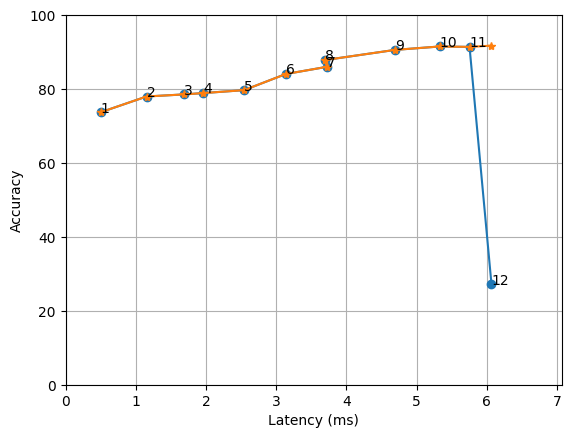

In [25]:
import matplotlib.pyplot as plt


num_layers=12
pl_latency = []
pl_acc = []

ground_truth = np.load("/Users/tuhinkhare/Work/GaTech-MSCS/Fall-24/CS-8803-SMR/SysMLTeam12/plotting/saved_models/bert_base-SST-2-two_stage/each_layer.npy")
print(ground_truth)

for layer in range(num_layers):
    path = f"/Users/tuhinkhare/Work/GaTech-MSCS/Fall-24/CS-8803-SMR/SysMLTeam12/plotting-per-layer/{layer}/saved_models/bert_base-SST-2-two_stage/accLat_75_100.npy"
    data = list(np.load(path, allow_pickle=True))
    latency = data[1][layer+1]*100
    accuracy = data[3][layer+1]*100
    pl_latency.append(latency)
    pl_acc.append(accuracy)

fig, ax = plt.subplots()

for i, label in enumerate([str(x+1) for x in range(num_layers)]):
    ax.annotate(label, (pl_latency[i], pl_acc[i]))


ax.plot(pl_latency, pl_acc, marker='o')
ax.plot(pl_latency, [x*100 for x in ground_truth], marker='*')
ax.set_xlabel("Latency (ms)")
ax.set_ylabel("Accuracy")
ax.set_xlim(xmin=0, xmax=max(pl_latency)+1)
ax.set_ylim(ymin=0, ymax=100)
ax.grid(True)

# note = num_sampels passed from layer, latency for h elayers, accuracy for the layer

In [4]:
path = "/Users/tuhinkhare/Work/GaTech-MSCS/Fall-24/CS-8803-SMR/SysMLTeam12/plotting/saved_models/bert_base-SST-2-two_stage/each_layer.npy";
data = np.load(path, allow_pickle=True);
print(data)

[0.73738532 0.77981651 0.78555046 0.78899083 0.79701835 0.84059633
 0.86009174 0.87844037 0.9059633  0.91513761 0.91399083 0.91743119]


In [47]:
acc_buckets = {}
# for acc in range(60, 100, 5):
#     acc_buckets[acc] = []

for e in entropies:
    for exit_layer in data_pl[e][3]:
        acc = int(data_pl[e][3][exit_layer] * 20) * 5
        if acc >= 60:
            if acc not in acc_buckets:
                acc_buckets[acc] = []
            latency = int(data_pl[e][1][exit_layer] * 1000)
            exit_layer_count = data_pl[e][0][exit_layer]
            acc_buckets[int(acc/5)*5].append((latency, exit_layer, e, exit_layer_count))

for acc in acc_buckets:
    print(acc, sorted(acc_buckets[acc]))


90 [(21, 1, 0.5, 107), (32, 2, 0.3, 299), (35, 2, 0.2, 200), (48, 3, 0.05, 54), (92, 6, 0.15, 102), (96, 6, 0.2, 96), (99, 6, 0.05, 89), (102, 7, 0.001, 13), (111, 7, 0.15, 114), (111, 7, 0.3, 89), (120, 8, 0.15, 104), (123, 8, 0.1, 138), (128, 8, 0.2, 82), (177, 12, 0.0, 872)]
100 [(30, 2, 0.01, 8), (32, 2, 0.001, 2), (35, 2, 0.005, 2), (37, 2, 0.05, 54), (47, 3, 0.005, 9), (47, 3, 0.01, 15), (62, 4, 0.005, 23), (65, 4, 0.05, 60), (72, 4, 0.001, 3), (74, 5, 0.005, 9), (78, 5, 0.1, 33), (79, 5, 0.01, 12), (80, 5, 0.001, 7), (80, 5, 0.05, 23), (99, 6, 0.001, 32), (105, 7, 0.005, 46), (119, 8, 0.6, 5), (128, 9, 0.6, 2), (154, 11, 0.15, 2), (156, 11, 0.3, 2), (158, 11, 0.4, 1), (159, 11, 0.001, 15), (175, 11, 0.1, 8), (219, 12, 0.5, 1)]
85 [(16, 1, 0.6, 271), (32, 2, 0.4, 385), (34, 2, 0.5, 421), (47, 3, 0.3, 111), (50, 3, 0.4, 98), (61, 4, 0.15, 90), (64, 4, 0.1, 69), (67, 4, 0.2, 91), (79, 5, 0.3, 50), (87, 5, 0.2, 44), (91, 6, 0.5, 51), (95, 6, 0.4, 58), (95, 6, 0.6, 22), (102, 6, 0.3,

In [61]:
# Accuracy is prioritized. We acheive the highest accuracy possible within the latency budget.
def get_entropies(targt_accuracy, target_latency):
    entropies = [(0, 0, 10)] * 12 # e, acc, latency
    for acc in acc_buckets:
        if acc < targt_accuracy:
            continue
        for latency, exit_layer, e, _ in acc_buckets[acc]:
            if latency > target_latency:
                continue
            if entropies[exit_layer][1] < acc or (entropies[exit_layer][1] == acc and entropies[exit_layer][2] > latency):
                entropies[exit_layer] = (e, acc, latency)
   
    res = []
    for e, _, _ in entropies:
        res.append(e)
    
    for i in range(len(res) - 1, 0, -1):
        if res[i] != 0:
            res[i] = 1
            break
    return res

print("for 90% acc, 100ms latency: ", get_entropies(90, 100))
print("for 90% acc, 150ms latency: ", get_entropies(90, 150))
print("for 80% acc, 150ms latency: ", get_entropies(80, 150))
print("for 80% acc, 120ms latency: ", get_entropies(80, 120))
print("for 70% acc, 120ms latency: ", get_entropies(70, 120))
print("for 70% acc, 100ms latency: ", get_entropies(70, 100))
            
            

for 90% acc, 100ms latency:  [0, 0.4, 0.01, 0.005, 0.005, 0.005, 1, 0, 0, 0, 0, 0]
for 90% acc, 150ms latency:  [0, 0.4, 0.01, 0.005, 0.005, 0.005, 0.001, 0.005, 0.6, 0.6, 1, 0]
for 80% acc, 150ms latency:  [0, 0.4, 0.01, 0.005, 0.005, 0.005, 0.001, 0.005, 0.6, 0.6, 1, 0]
for 80% acc, 120ms latency:  [0, 0.4, 0.01, 0.005, 0.005, 0.005, 0.001, 0.005, 1, 0, 0, 0]
for 70% acc, 120ms latency:  [0, 0.4, 0.01, 0.005, 0.005, 0.005, 0.001, 0.005, 1, 0, 0, 0]
for 70% acc, 100ms latency:  [0, 0.4, 0.01, 0.005, 0.005, 0.005, 1, 0, 0, 0, 0, 0]


In [79]:
print("for 75% acc, 100ms latency: ", get_entropies(75, 100))

for 75% acc, 100ms latency:  [0, 0.4, 0.01, 0.005, 0.005, 0.005, 1, 0, 0, 0, 0, 0]


In [5]:
import matplotlib.pyplot as plt

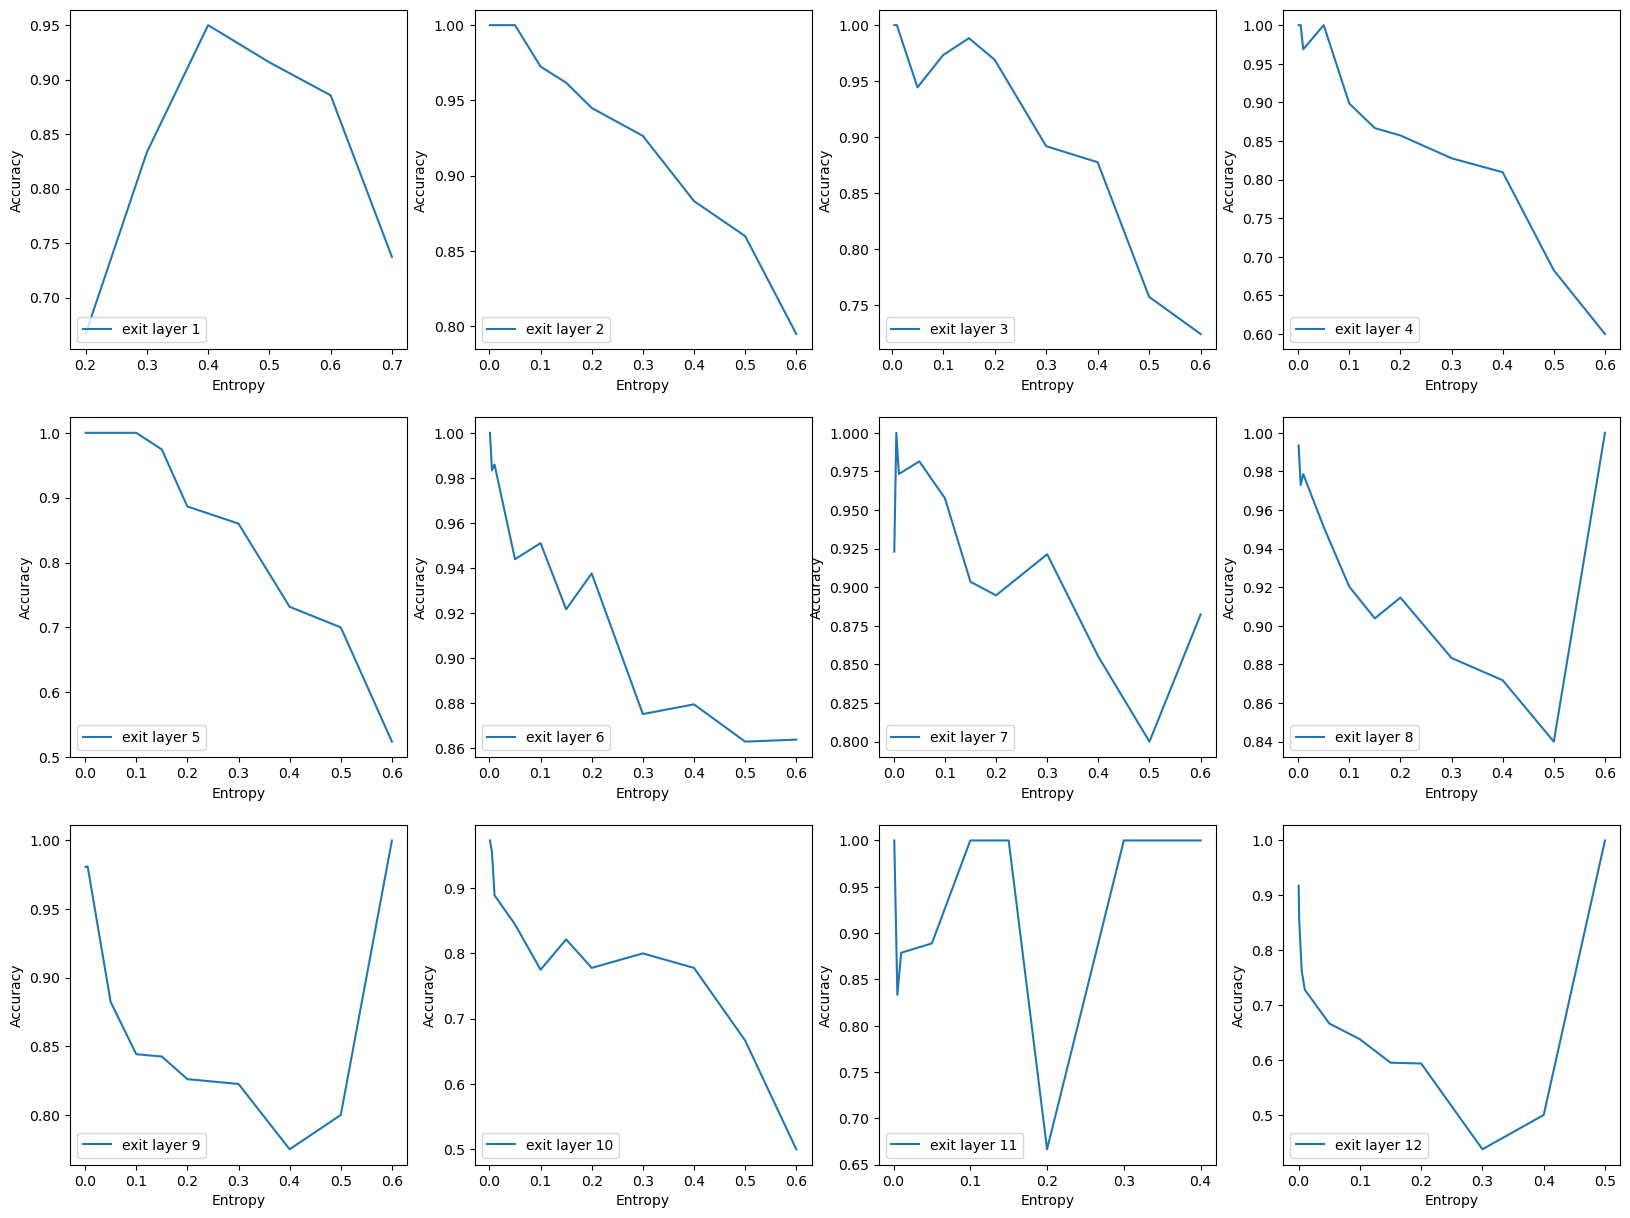

In [40]:
def plot_accuracy_entropy(data_pl, entropies):
    fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(20, 15))
    for exit_layer in data_pl[0][0]:
        xvals=[]
        yvals=[]
        for e in entropies:
            if exit_layer in data_pl[e][3]:
                xvals.append(e)
                yvals.append(data_pl[e][3][exit_layer])
        ax = plt.subplot(3, 4, exit_layer)
        ax.set_xlabel('Entropy')
        ax.set_ylabel('Accuracy')
        ax.plot(xvals, yvals, label='exit layer {}'.format(exit_layer))
        ax.legend(loc='lower left')
    plt.show()
plot_accuracy_entropy(data_pl, entropies)

In [66]:
data_accLat_90_150 = np.load('./../plotting2/saved_models/bert_base-SST-2-two_stage/accLat_{}_{}.npy'.format(90, 150), allow_pickle=True)
print(data_accLat_90_150)

[{1: 0, 2: 424, 3: 0, 4: 0, 5: 0, 6: 6, 7: 3, 8: 106, 9: 310, 10: 17, 11: 6, 12: 0}
 {1: 0, 2: 0.030887295614998294, 3: 0, 4: 0, 5: 0, 6: 0.08540070056915283, 7: 0.09722900390625, 8: 0.11355175612107762, 9: 0.12480902594904746, 10: 0.13616587133968577, 11: 0.15102994441986084, 12: 0}
 0.45670871559633025
 {2: 0.8915094339622641, 8: 0.9811320754716981, 9: 0.864516129032258, 10: 0.6470588235294118, 11: 0.8333333333333334, 7: 1.0, 6: 1.0}]


In [ ]:
data_accLat_90_150 = np.load('./../plotting2/saved_models/bert_base-SST-2-two_stage/accLat_{}_{}.npy'.format(90, 150), allow_pickle=True)
print(data_accLat_90_150)

In [77]:
def compute_overall_accuracy_latency(data_accLat):
    total = 0
    acc = 0
    latency = 0
    for exit_layer in data_accLat[0]:
        if exit_layer in data_accLat[3]:
            total += data_accLat[0][exit_layer]
            acc += data_accLat[0][exit_layer] * data_accLat[3][exit_layer]
            latency += data_accLat[0][exit_layer] * data_accLat[1][exit_layer]
    return acc/total, latency/total

acc, latency = compute_overall_accuracy_latency(data_accLat_90_150)
print("Target Accuracy: 90%, Average Latency: 150ms ")
print(f"Achieved Accuracy: {round(acc*100)}%, Average Latency: {round(latency * 1000)}ms")

Target Accuracy: 90%, Average Latency: 150ms 
Achieved Accuracy: 89%, Average Latency: 78ms


In [78]:
data_accLat_80_120 = np.load('./../plotting2/saved_models/bert_base-SST-2-two_stage/accLat_{}_{}.npy'.format(80, 120), allow_pickle=True)
acc, latency = compute_overall_accuracy_latency(data_accLat_80_120)
print("Target Accuracy: 80%, Average Latency: 120ms ")
print(f"Achieved Accuracy: {round(acc*100)}%, Average Latency: {round(latency * 1000)}ms")

Target Accuracy: 80%, Average Latency: 120ms 
Achieved Accuracy: 88%, Average Latency: 90ms


In [81]:
data_accLat_75_100 = np.load('./../plotting2/saved_models/bert_base-SST-2-two_stage/accLat_{}_{}.npy'.format(75, 100), allow_pickle=True)
acc, latency = compute_overall_accuracy_latency(data_accLat_75_100)
print("Target Accuracy: 75%, Average Latency: 100ms ")
print(f"Achieved Accuracy: {round(acc*100)}%, Average Latency: {round(latency * 1000)}ms")

Target Accuracy: 75%, Average Latency: 100ms 
Achieved Accuracy: 85%, Average Latency: 70ms
